ver3 加入座標當state

In [ ]:
pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import packages

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import glob
import cv2
from PIL import Image as im

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Coordinate Q learning

## build Q learning

In [ ]:
# 實際進行訓練的 evaluation network
class Eval_Q_Model(tf.keras.Model):
  # Evaluate Q Model 的模型架構
  def __init__(self, num_actions):
    super().__init__('mlp_q_network')
    self.layer1 = layers.Dense(10, activation='relu')
    self.logits = layers.Dense(num_actions, activation=None)

  def call(self, inputs):
    x = tf.convert_to_tensor(inputs)
    layer1 = self.layer1(x)
    logits = self.logits(layer1)
    return logits

In [ ]:
# 久久更新一次的 evaluation network
class Target_Q_Model(tf.keras.Model):
  # Target Q Model 的模型架構(不更新layer權重)
  def __init__(self, num_actions):
    super().__init__('mlp_q_network_1')
    self.layer1 = layers.Dense(10, trainable=False, activation='relu')
    self.logits = layers.Dense(num_actions, trainable=False, activation=None)

  def call(self, inputs):
    x = tf.convert_to_tensor(inputs)
    layer1 = self.layer1(x)
    logits = self.logits(layer1)
    return logits

In [ ]:
class DeepQNetwork:
  def __init__(self, n_actions, n_features, eval_model, target_model):
    # 利用dic儲存參數
    self.params = {
        'n_actions': n_actions,     # actions數量
        'n_features': n_features,    # features數量 
        'learning_rate': 0.01,
        'reward_decay': 0.9,
        'e_greedy': 0.9,         # 選擇隨機action的機率
        'replace_target_iter': 300,   # 從 Eval_Q_Model 更新 Target_Q_Model 需要的迭代次數
        'memory_size': 500,
        'batch_size': 32,
        'e_greedy_increment': None
        }

    # total learning step
    self.learn_step_counter = 0
    # epsilon 表機率，訓練過程中有 epsilon 的機率 agent 會選擇隨機
    self.epsilon = 0 if self.params['e_greedy_increment'] is not None else self.params['e_greedy']
    # initialize zero memory ，每個 memory 中的 experience 大小為 (state + next state + reward + action)
    self.memory = np.zeros((self.params['memory_size'], self.params['n_features'] * 2 + 2))

    self.eval_model = eval_model
    self.target_model = target_model

    self.eval_model.compile(
        optimizer=RMSprop(learning_rate=self.params['learning_rate']),
        loss='mse'
        )
    self.cost_his = []

  ## 儲存經驗
  def store_transition(self, s, a, r, s_):
    if not hasattr(self, 'memory_counter'):
      self.memory_counter = 0

    # 打包agent經驗
    transition = np.hstack((s, [a, r], s_))

    # 用新memory取代舊memory
    index = self.memory_counter % self.params['memory_size']
    self.memory[index, :] = transition
    self.memory_counter += 1

  ## 決定是否具有隨機以及隨機的方式
  def choose_action(self, observation):
    # to have batch dimension when feed into tf placeholder
    observation = observation[np.newaxis, :]

    if np.random.uniform() < self.epsilon:
    # 透過觀察得到每個 action 的 q 值
      actions_value = self.eval_model.predict(observation)
      print(actions_value)
      action = np.argmax(actions_value)
    else: # 隨機移動
      action = np.random.randint(0, self.params['n_actions'])
    return action

  ## 從 memory 中取樣學習
  def learn(self):
    # 從 memory 取樣 batch memory
    if self.memory_counter > self.params['memory_size']:
      sample_index = np.random.choice(self.params['memory_size'], size=self.params['batch_size'])
    else:
      sample_index = np.random.choice(self.memory_counter, size=self.params['batch_size'])

    batch_memory = self.memory[sample_index, :]

    # 計算現在 eval net 和 target net 得出 Q value 的落差
    q_next = self.target_model.predict(batch_memory[:, -self.params['n_features']:])
    q_eval = self.eval_model.predict(batch_memory[:, :self.params['n_features']])

    # 根據 q_eval 改變 q_target
    q_target = q_eval.copy()

    batch_index = np.arange(self.params['batch_size'], dtype=np.int32)
    eval_act_index = batch_memory[:, self.params['n_features']].astype(int)
    reward = batch_memory[:, self.params['n_features'] + 1]

    q_target[batch_index, eval_act_index] = reward + self.params['reward_decay'] * np.max(q_next, axis=1)

    # check to replace target parameters
    if self.learn_step_counter % self.params['replace_target_iter'] == 0:
      for eval_layer, target_layer in zip(self.eval_model.layers, self.target_model.layers):
        target_layer.set_weights(eval_layer.get_weights())
      print('\ntarget_params_replaced\n')

    # train eval network
    self.cost = self.eval_model.train_on_batch(batch_memory[:, :self.params['n_features']], q_target)
    self.cost_his.append(self.cost)

    # 增加 epsilon ，使 agent 傾向不隨機
    self.epsilon = self.epsilon + self.params['e_greedy_increment'] if self.epsilon < self.params['e_greedy'] else self.params['e_greedy']
    self.learn_step_counter += 1

  def plot_cost(self):
    plt.plot(np.arange(len(self.cost_his)), self.cost_his)
    plt.ylabel('Cost')
    plt.xlabel('training steps')
    plt.show()

In [ ]:
def run_cleaner(ag, RL):
  step = 0

  action = 1
  n_states = ag.get_env()
  n_states = np.hstack((n_states, ag.locx, ag.locy))
  error_flag, reward, done_flag, n_states_new = ag.step(action)
  RL.store_transition(n_states, action, reward, n_states_new)

  for episode in range(300):
    # RL 選擇 action
    action = RL.choose_action(n_states_new)
    # 執行 action 並得到下一階段 info
    n_states = n_states_new
    error_flag, reward, done_flag, n_states_new = ag.step(action)
    RL.store_transition(n_states, action, reward, n_states_new)

    if (step > 200) and (step % 5 == 0):
      RL.learn()

    # break while loop when end of this episode
    if done_flag:
      print('Episode finished after {} timesteps, total rewards {}'.format(step+1, rewards))
      break
    step += 1
  # end of game
  print('over')

## build enviroment

In [ ]:
class enviroment:
	def __init__(self):
		self.env = []
		self.wall = []

	def initial(self, setini):
		#	setini[0]：環境長	setini[1]：環境寬
		self.env = np.full((setini[0]+2, setini[1]+2), False, dtype=bool)
		self.wall = np.full((setini[0]+2, setini[1]+2), False, dtype=bool)

		#	包邊 w
		for j in range(setini[1]+2):
			self.wall[0][j] = 1
			self.wall[setini[0]+1][j] = 1
		for i in range(setini[0]+2):
			self.wall[i][0] = 1
			self.wall[i][setini[1]+1] = 1

	def set_wall(self, wall):
		for i in wall:
			if( i[1]>=np.size(self.env,1) or i[0]>=np.size(self.env,0) ): print("error",i)
			else:	self.wall[ i[1]+1 ][ i[0]+1 ] = 1

	def play(self):
		for i in range(np.size(self.env,0)):
			for j in range(np.size(self.env,1)):
				if(self.wall[i][j]):	print("w", end=" ")
				elif(self.env[i][j]):	print("■", end=" ")
				else:	print("□", end=" ")
			print("")

def agent_play_env(x, y, env):
	x_bound = np.size(env.env,1)
	y_bound = np.size(env.env,0)
	for i in range(-1,2,1):
		for j in range(-1,2,1):
			if( (j+x+1)>=x_bound or (i+y+1)>=y_bound ): print("error",i+x,j+j, end=" ")
			elif(i==0 and j==0):	print("a", end=" ")
			elif(env.wall[y+i+1][x+j+1]):	print("w", end=" ")
			elif(env.env[y+i+1][x+j+1]):	print("■", end=" ")
			else:	print("□", end=" ")
		print("")

In [ ]:
def agent_play_env_full(x, y, env):
  x_bound = np.size(env.env,1)
  y_bound = np.size(env.env,0)
  for i in range(np.size(env.env,0)):
    for j in range(np.size(env.env,1)):
      if(i==y+1 and j==x+1):	print("a", end=" ")
      elif(env.wall[i][j]):	print("w", end=" ")
      elif(env.env[i][j]):	print("■", end=" ")
      else:	print("□", end=" ")
    print("")

def agent_get_env_full(x, y, env):
  x_bound = np.size(env.env,1)
  y_bound = np.size(env.env,0)
  pic = np.zeros(x_bound*y_bound)
  for i in range(y_bound):
    for j in range(x_bound):
      if(i==y+1 and j==x+1):	pic[j+y_bound*i] = 0
      elif(env.wall[i][j]):	pic[j+y_bound*i] = 0
      elif(env.env[i][j]):	pic[j+y_bound*i] = 0
      else:	pic[j+y_bound*i] = 225
  pic = pic.reshape((y_bound,x_bound))  
  return pic

def agent_play_env(x, y, env):
  x_bound = np.size(env.env,1)
  y_bound = np.size(env.env,0)
  for i in range(-1,2,1):
    for j in range(-1,2,1):
      if( (j+x+1)>=x_bound or (i+y+1)>=y_bound ): print("error",i+x,j+j, end=" ")
      elif(i==0 and j==0):  print("a", end=" ")
      elif(env.wall[y+i+1][x+j+1]):	print("w", end=" ")
      elif(env.env[y+i+1][x+j+1]):  print("■", end=" ")
      else:	print("□", end=" ")
    print("")

def agent_get_env(x, y, env):
  state =  np.zeros(9)
  for i in range(-1,2,1):
    for j in range(-1,2,1):
      if(i==0 and j==0):  pass
      elif(env.wall[y+i+1][x+j+1]): state[(j+1)+3*(i+1)] = 1
      elif(env.env[y+i+1][x+j+1]):  state[(j+1)+3*(i+1)] = 2
      else:	state[(j+1)+3*(i+1)] = 0
  return state

def agent_wall_test(x, y, env):
  x_bound = np.size(env.env,1)
  y_bound = np.size(env.env,0)
  if( (x+1)>=x_bound or (y+1)>=y_bound ): return 2
  elif(env.wall[y+1][x+1]==1):	return 1
  else:	return 0

class agent():
  def __init__(self):
    self.locx = -1
    self.locy = -1
    self.flag = 0
    self.bound_error = 0
    self.n_actions = 2
    self.n_features = np.zeros(9)
    self.env = 0

  def initial(self, env):
    self.env = env
    self.locx = 0
    self.locy = 0

  def set_loc(self, y, x):
    flag = agent_wall_test(x, y, self.env)
    if(flag==1):  print("wall_error")
    elif(flag==2):  print("bound_error")
    else:
      self.locx = x
      self.locy = y

  def loc_test(self, y, x):
    flag = agent_wall_test(x, y, self.env)
    if(flag==1):
      print("wall_error")
    elif(flag==2):	
      print("bound_error")
    return flag

  def go_right(self):
    self.locx += 1

  def go_left(self):
    self.locx -= 1

  def go_up(self):
    self.locy -= 1

  def go_down(self):
    self.locy += 1

  def go(self,do):
    if(do==0):	
      flag = self.loc_test(self.locy-1, self.locx)
      if(flag==0):  self.go_up()
    elif(do==1):
      flag = self.loc_test(self.locy+1, self.locx)
      if(flag==0):  self.go_down()
    elif(do==2):
      flag = self.loc_test(self.locy, self.locx-1)
      if(flag==0):  self.go_left()
    elif(do==3):
      flag = self.loc_test(self.locy, self.locx+1)
      if(flag==0):  self.go_right()
    self.flag = flag

  def get_env(self):
    return agent_get_env(self.locx, self.locy, self.env)

  def step(self,action):
    self.go(action)
    done = False

    # reward設計
    if(self.flag==1): reward = -1
    elif(self.flag==2):
      self.wall_error += 1
      reward = -1*(self.wall_error if self.wall_error<4 else 4)
    else: reward = 0.1 

    # 取得下一階段state
    state = agent_get_env(self.locx, self.locy, self.env)
#ver3# 替state加上座標
    state = agent_get_env(self.locx, self.locy, self.env)
    state = np.hstack((state, self.locx, self.locy))

    # 是否end game
    if(self.bound_error>10):  done = True

    return self.flag, reward, done ,state

  def play(self):
    print("Location：", self.locx, self.locy)
    agent_play_env(self.locx, self.locy, self.env)

  def full_play(self):
    print("Location：", self.locx, self.locy)
    agent_play_env_full(self.locx, self.locy, self.env)

  def full_get(self):
    pic = agent_get_env_full(self.locx, self.locy, self.env)
    return pic

## main

10*10複雜空間

In [ ]:
# 環境初始化
env1 = enviroment()
env1.initial([10,10])
wall = np.array( [ [5, 0], [5, 1], [7, 5], [7, 6], [8, 6], [9, 6] ] )
wall2 = np.array( [ [2, 5], [2, 6], [2, 7], [2, 8], [2, 9] ] )
wall3 = np.array( [ [1, 1], [1, 2], [2, 1], [2, 2] ] )
env1.set_wall( wall )
env1.set_wall( wall2 )
env1.set_wall( wall3 )

# agent初始化
ag1 = agent()
ag1.initial(env1)
ag1.set_loc(0, 0)

eval_model_1 = Eval_Q_Model(num_actions=4)
target_model_1 = Target_Q_Model(num_actions=4)
RL_1 = DeepQNetwork(4, 11, eval_model_1, target_model_1)
RL_1.params['memory_size'] = 500
RL_1.params['e_greedy'] = 0.4
for i in range(10):
  run_cleaner(ag1, RL_1)

1/1 [==============================] - 0s 65ms/step
[[ 0.55010784 -0.50505435 -0.6570138   0.4908063 ]]
1/1 [==============================] - 0s 17ms/step
[[ 0.6322065  -0.05771156 -0.28978163  0.19652164]]
wall_error
wall_error
wall_error
1/1 [==============================] - 0s 20ms/step
[[ 0.6322065  -0.05771156 -0.28978163  0.19652164]]
wall_error
1/1 [==============================] - 0s 17ms/step
[[ 0.29739472 -0.07326722  0.17814595 -0.16419911]]
wall_error
1/1 [==============================] - 0s 21ms/step
[[ 0.29739472 -0.07326722  0.17814595 -0.16419911]]
wall_error
1/1 [==============================] - 0s 20ms/step
[[ 0.29739472 -0.07326722  0.17814595 -0.16419911]]
wall_error
1/1 [==============================] - 0s 17ms/step
[[ 0.29739472 -0.07326722  0.17814595 -0.16419911]]
wall_error
1/1 [==============================] - 0s 20ms/step
[[ 0.29739472 -0.07326722  0.17814595 -0.16419911]]
wall_error
1/1 [==============================] - 0s 20ms/step
[[ 0.29739472 -0.

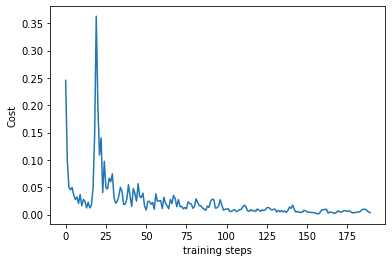

In [ ]:
RL_1.plot_cost()

## predict test

In [ ]:
# agent初始化
ag = agent()
ag.initial(env1)
ag.set_loc(0, 0)

In [ ]:
for i in range(100):
  state = ag.get_env()
  state = np.hstack((state, ag.locx, ag.locy))
  ag.go(RL_1.choose_action(state))
  picture = ag.full_get()
  picture = scipy.ndimage.zoom(picture, 500, order=0)
  picture = im.fromarray(picture)
  picture = picture.convert('RGB')
  picture = picture.resize((512,512))
  for j in range(5):
    picture.save('/content/drive/MyDrive/人工智慧導論/人工智慧導論_project/map walk/'+str(30*i+j)+'.jpeg', cmap='gray')

wall_error
1/1 [==============================] - 0s 20ms/step
[[-0.07003759  0.9225809  -0.28115422  0.24409874]]
wall_error
1/1 [==============================] - 0s 25ms/step
[[ 0.73031676  1.4339569  -0.00944902  1.2894976 ]]
1/1 [==============================] - 0s 24ms/step
[[ 0.73031676  1.4339569  -0.00944902  1.2894976 ]]
wall_error
1/1 [==============================] - 0s 28ms/step
[[0.9662903  1.6134483  0.11639939 1.4393188 ]]
1/1 [==============================] - 0s 17ms/step
[[1.214909  1.8172084 0.3034721 1.5997194]]
1/1 [==============================] - 0s 19ms/step
[[1.1914026 1.9257367 1.4225601 0.5331684]]
wall_error
1/1 [==============================] - 0s 21ms/step
[[1.4635272  2.0209684  0.49054468 1.76012   ]]
1/1 [==============================] - 0s 18ms/step
[[1.4635272  2.0209684  0.49054468 1.76012   ]]
1/1 [==============================] - 0s 21ms/step
[[1.7121458  2.2247288  0.67761725 1.9205207 ]]
1/1 [==============================] - 0s 16ms/step


In [ ]:
path = "/content/drive/MyDrive/人工智慧導論/人工智慧導論_project/map walk/*.jpeg" 
result_name = '/content/drive/MyDrive/人工智慧導論/人工智慧導論_project/output.mp4'

frame_list = sorted(glob.glob(path))
print("frame count: ",len(frame_list))


fps = 5
shape = cv2.imread(frame_list[0]).shape # delete dimension 3
size = (shape[1], shape[0])
print("frame size: ",size)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(result_name, fourcc, fps, size)

for idx, path in enumerate(frame_list):
    frame = cv2.imread(path)
    # print("\rMaking videos: {}/{}".format(idx+1, len(frame_list)), end = "")
    current_frame = idx+1
    total_frame_count = len(frame_list)
    percentage = int(current_frame*30 / (total_frame_count+1))
    print("\rProcess: [{}{}] {:06d} / {:06d}".format("#"*percentage, "."*(30-1-percentage), current_frame, total_frame_count), end ='')
    out.write(frame)

out.release()
print("Finish making video !!!")

frame count:  500
frame size:  (512, 512)
Process: [#############################] 000500 / 000500Finish making video !!!


# Reference
  1. https://www.youtube.com/watch?v=a4Yfz2FxXiY
  2. https://towardsdatascience.com/what-are-stable-diffusion-models-and-why-are-they-a-step-forward-for-image-generation-aa1182801d46
  3. https://zhuanlan.zhihu.com/p/70009692
  4. https://mofanpy.com/

# Build GAN enviroment

In [ ]:
!git clone https://github.com/eriklindernoren/PyTorch-GAN

In [ ]:
# 移動至PyTorch-GAN
os.chdir(os.path.dirname(os.path.abspath("__file__"))+'/PyTorch-GAN')

In [ ]:
# 安裝相關需求檔案
!pip3 install -r requirements.txt

## Build Generator

In [ ]:
import torch.nn.functional as F


def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    #encoder
    self.model = nn.Module

  def call(self, inputs, training=None):
    img = self.model(z)
    img = img.view(img.size(0), *img_shape)
    return img

## Build Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(int(np.prod(img_shape)), 512),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(256, 1),
      nn.Sigmoid(),
    )

  def forward(self, img):
    img_flat = img.view(img.size(0), -1)
    validity = self.model(img_flat)
    return validity

## Loss function

In [ ]:
adversarial_loss = torch.nn.BCELoss()